In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ipywidgets as widgets
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import Isomap

plt.rc('text', usetex=True)

### Dataset preparation

We will classify questions of users provided in the [dataset](https://www.kaggle.com/ananthu017/question-classification). According to the selected dataset questions are classified acoording their content into `6` classes:

|Class Abbreviation|  Description  |
|:-----:|:-----|
| ABBR | question asking for an *abbreviation* description|
| DESC | question asking for an *description* of smth.|
| ENTY | question asking for the name of *entity* (general facts)|
| HUMAN | question asking for the human related noun (name, profession etc.)|
| LOC | question asking for a *location* name|
| NUM | question asking for a *numerical* information (date, quantity)|

Questions are presented as a string.
We use utilize term frequency–inverse document frequency [(TF-IDF)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) method for representation of text string as vector.

In [2]:
dat = pd.read_csv(os.getcwd() + "/data/Question_Classification_Dataset.csv")
col = ["Questions", "Category1"]
dat = dat[col]
dat["Category_id"] = dat["Category1"].factorize()[0]
class_num = dat["Category_id"].unique()

In [3]:
dat[:5]

,Questions,Category1,Category_id
0,How did serfdom develop in and then leave Russ...,DESC,0
1,What films featured the character Popeye Doyle ?,ENTY,1
2,How can I find a list of celebrities ' real na...,DESC,0
3,What fowl grabs the spotlight after the Chines...,ENTY,1
4,What is the full form of .com ?,ABBR,2


#### Let us analyze number of each class items in the dataset

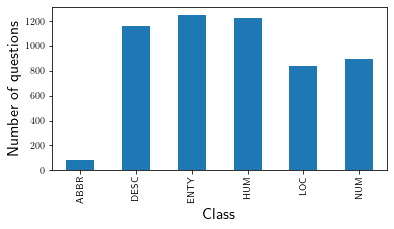

In [4]:
fig = plt.figure(figsize=(6,3))
dat.groupby("Category1").Questions.count().plot.bar(ylim=0)
plt.xlabel("Class", fontsize=16)
plt.ylabel("Number of questions", fontsize=16)
plt.show()

Evidently, `ENTY` class is the largest group of the dataset whereas questions of `ABBR` class is the smalles one.
The minority of `ABBR` class in the dataset in comparison with other classes will influence on the training of the models in the way of missclassification of this class questions. 

### Vectorization of questions strings

For each question in dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency. We will utilize `sklearn.feature_extraction.text.TfidfVectorizer` to calculate a TF-IDF vector for each question.

In the context of our task, TF-IDF is a numerical statistic which reflects the importance of the word in the particular question of the given questions set. The weight of each word is proportional to the frequency of this word in the question and inversely proportional to its frequency in the whole questions set.
The *Term Frequency* of the particular word $w$ in the question $q$ of the question set $Q = \{q_i\}$ is determined as

$\text{TF}(w, q) = \dfrac{n_w}{N_q}$ where $n_w$ is a frequency of the word $w$
 in the question $q$ and $N_q$ is a total number of words in the question $q$.

The *Inverse Documents Frequency* is inverse frequency of the word $w$ in the questions of $Q$. For each word in the frame of $Q$ IDF is introduced as follows 

$\text{IDF}(w) = \log\dfrac{N_Q}{N_{w\in q}}$ where $N_Q$ is a total number of questions in $Q$ and $N_{w\in q}$ is a number of questions in the $Q$ with word $w$. IDF decrease weight of widespread words in the questions set $Q$.

TF-IDF of particular word in the question is determinde as $\text{TF-IDF}(w, q) = \text{TF}(w, q) \text{IDF}(w)$. Words with large frequency in the question and low frequency in the questions set will have the large TF-IDF measure.
 
We use the following parameters of `TfidfVectorizer`:

* `min_df` is the minimum numbers of questions a word must be present in to be kept.
* `encoding` we have a deal with questions in English so we use `'latin-1'` 
* `ngram_range` the lower and upper boundary of the range of n-values for different n-grams,(1, 2) means unigrams and bigrams
* `stop_words` is set to English to remove all common pronouns ("a", "the", ...)
* `sublinear_df` is set to `True` to use a logarithmic form for the frequency


In [5]:
tfidf = TfidfVectorizer(min_df=4, encoding='latin-1', ngram_range=(1, 2), stop_words='english', sublinear_tf=True)
features = tfidf.fit_transform(dat.Questions).toarray()
labels = dat.Category_id

X_train = features[:3000]
Y_train = np.array(labels[:3000])

X_test = features[3000:]
Y_test = np.array(labels[3000:])

X_train4grid = features[:1000]
Y_train4grid = np.array(labels[:1000])

print(Y_train.shape, X_train.shape)

(3000,) (3000, 1596)


In [6]:
category_id_dat = dat[['Category1', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_id = dict(category_id_dat.values)
id_to_category = dict(category_id_dat.values[:, ::-1])
classes = category_id_dat.values[:, 0]
print(classes)

['DESC' 'ENTY' 'ABBR' 'HUM' 'NUM' 'LOC']


### Isomap 

Let us analyze questions-vectors separation in spece of reduced dimention with isomap method. We reduce inital dimention of vectors from 1596 to 3. Note, we get 200 vectors for illustration.

<IPython.core.display.Javascript object>


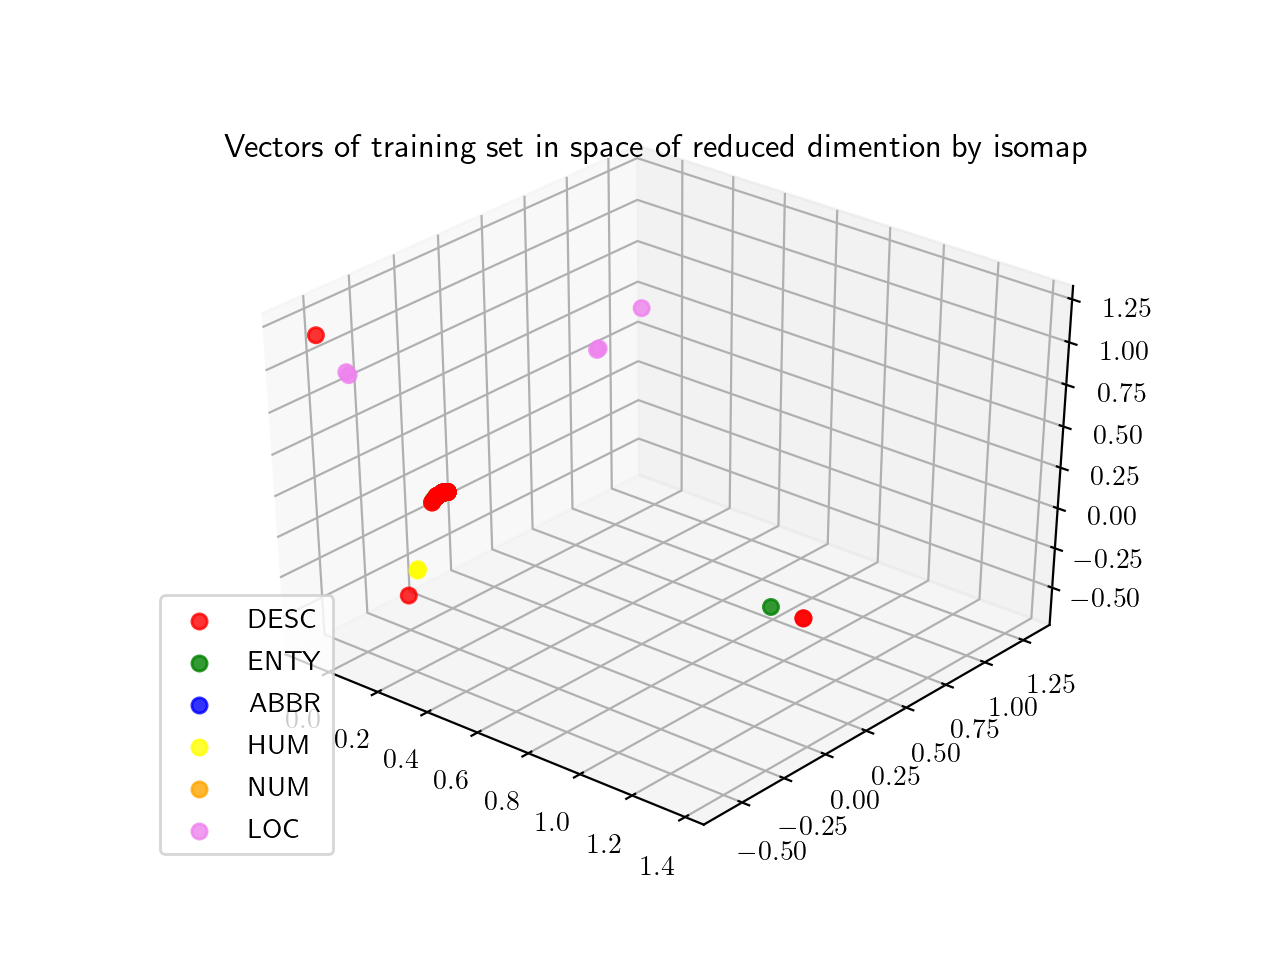

In [24]:
%matplotlib notebook
embedding = Isomap(n_components=3)
X_transformed = embedding.fit_transform(X_train[:200])

colors = ["red", "green", "blue", "yellow", "orange", "violet"]
merg_space = np.array([[list(X_transformed[i]), id_to_category[Y_train[i]], colors[Y_train[i]]] for i in range(len(X_transformed))])

enty = np.array(list(filter(lambda x: x[1] =='ENTY', merg_space)))

def ddplot():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    
    for item in classes:
        data = np.array(list(filter(lambda x: x[1] == item, merg_space)))
        x = [item[0] for item in data[:, 0]]
        y = [item[1] for item in data[:, 0]]
        z = [item[2] for item in data[:, 0]]
        color = colors[category_to_id[item]]
        ax.scatter(x, y, z, s=30, alpha=0.8, c=color, label=item)
    
    #ax.scatter(X_transformed[:, 0], X_transformed[:, 1], X_transformed[:, 2], edgecolors='none')


    plt.title('Vectors of training set in space of reduced dimention by isomap')
    plt.legend(loc=(0, 0))
    plt.show()

ddplot() 

### Classifier general class declaration
We declare a general classifier class which methods realise particular model from the list:
* SVM (`linear` an `rbf` kernel)
* Random forest classifier
* logistic regression classifier
* 

In [70]:
class Classifier:
    """
    The general class of classifier init. 
    Contains different classification methods. 
    Fields
        data -- dataset of items
        classes -- classes of items
    """
    def __init__(self, data, classes):
        """
        Parameters
            data -- list, vectors of training dataset
            classes -- list, classes in the training dataset
        """
        self.data = data
        self.classes = classes
    
    def plot_train_data_2d(self, clf):
        """
        Plot scatter plot of training set.
        """
        colors = ['r', 'b']
        xx, yy = np.meshgrid(np.linspace(0, 1.1, 200), np.linspace(0, 1.1, 200))
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
        plt.scatter(self.data[:, 0], self.data[:, 1], c=self.classes, cmap=plt.cm.RdBu_r, s=50, 
                    edgecolors='w', linewidth=1)
        plt.gca().set_aspect('equal', adjustable='box')

    def svm_classifier(self, kernel, C=1, gamma=1):
        """
        Function of SVM classifier realization.
        Parameters:
            kernel -- type of kernel
            C -- regularization parameter (penalty parameter of the error term)
            gamma -- kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
        Returns:
            model -- trained svm classifier
        """
        model = SVC(C=C, kernel=kernel, gamma=gamma)
        model.fit(self.data, self.classes)
        #self.plot_train_data_2d(model)
        return model
    
    def random_forest_classifier(self):
        """
        Function for random forest classification.
        Returns:
            model -- trained random forest classifier
        """
        model = RandomForestClassifier(n_jobs=2, n_estimators=100)
        model.fit(self.data, self.classes)
        return model
    
    def logistic_regression_classifier(self, C=1e5):
        """
        Function for classification with logistic regression method.
        Parameters:
            C -- regularization parameter
        Returns:
            model -- trained logregression model
        """
        model = LogisticRegression(C=C, solver='liblinear', multi_class='auto')
        model.fit(self.data, self.classes)
        return model
        
    @staticmethod
    def confusion_matrix(Y_test, Y_pred, xticklabels, yticklabels, title):
        conf_mat = confusion_matrix(Y_test, Y_pred)
        fig, ax = plt.subplots(figsize=(6,6))
        sns.heatmap(conf_mat, annot=True, fmt='d',
                    xticklabels=xticklabels, yticklabels=xticklabels)
        plt.ylabel("Actual", fontsize=16)
        plt.xlabel("Predicted",  fontsize=16)
        plt.title(title,  fontsize=18)
        plt.savefig(os.getcwd() + "/doc/imgs/conf_matr_{}.png".format(title.replace(" ", "_")), dpi=300)
        plt.show()
    
    @staticmethod
    def test_model(model, X_test, Y_test, model_name, xticks, yticks):
        """
        Function for testing model and collecting its summary.
        Parameters
            model -- classifier model
            X_test -- set of test vectors
            Y_test -- set of classes of test vectors
            model_name -- name of the model
            xticks -- labels for x axis of confusion matrix
            yticks -- labels for y axis of confusion matrix
        Returns
            confusion matrix of model
        """
        Y_pred = model.predict(X_test)
        Classifier.confusion_matrix(Y_test, Y_pred, xticks, yticks, model_name)
        
        

In [71]:
classifier = Classifier(X_train, Y_train)

### SVM with linear kernel

In [27]:
svm_model = classifier.svm_classifier("linear")

<IPython.core.display.Javascript object>


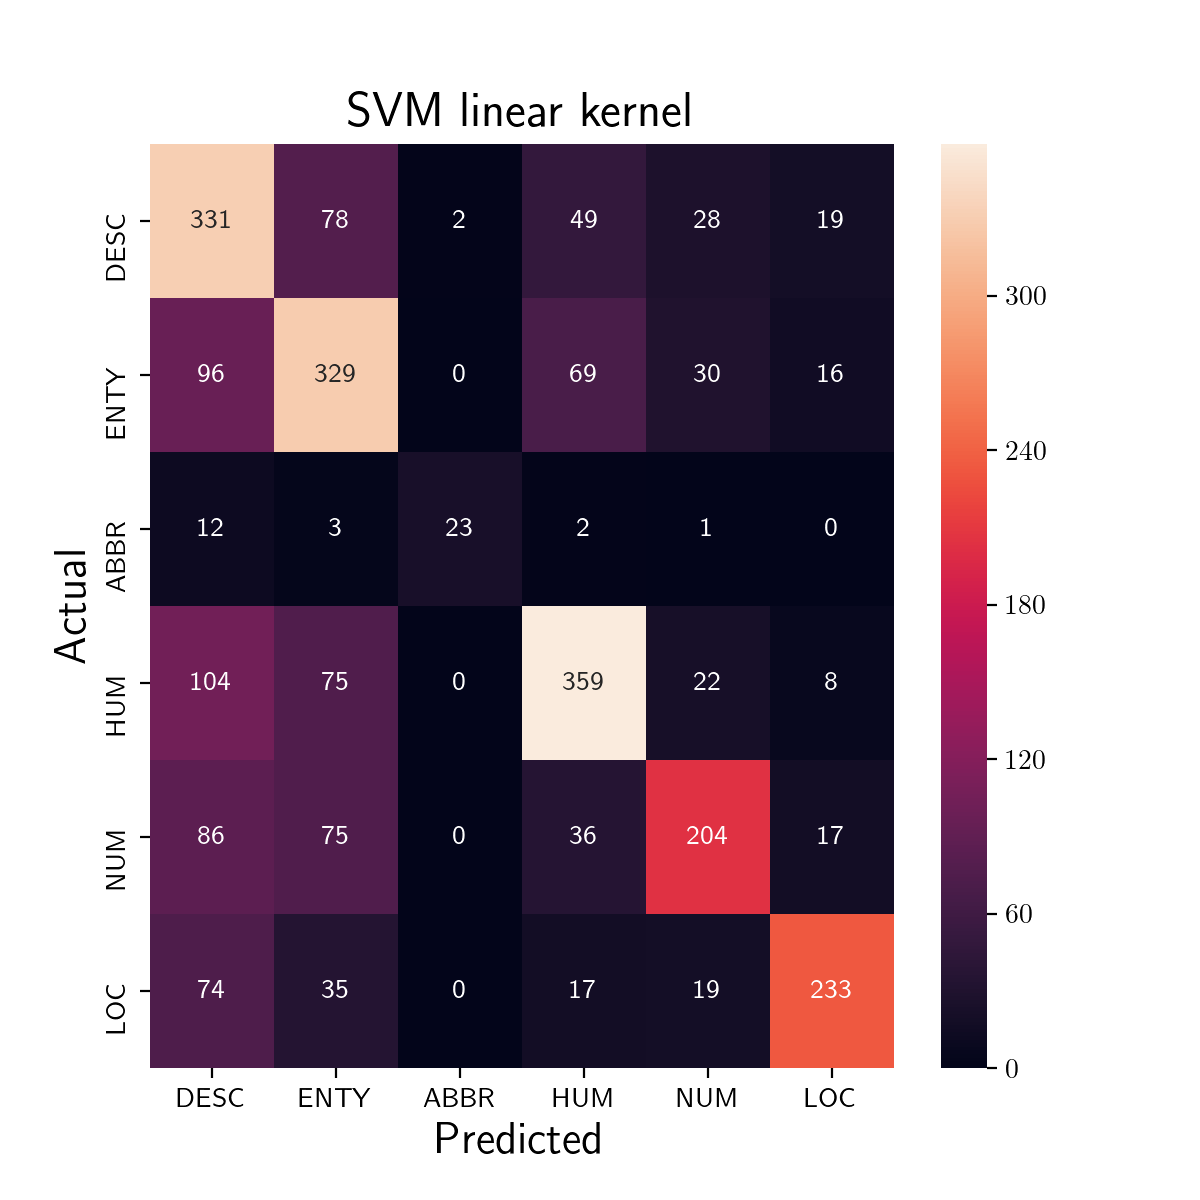

In [72]:
Classifier.test_model(svm_model, X_test, Y_test, "SVM linear kernel", category_id_dat.Category1.values, category_id_dat.Category1.values)


### SVM with RBF kernel

<IPython.core.display.Javascript object>


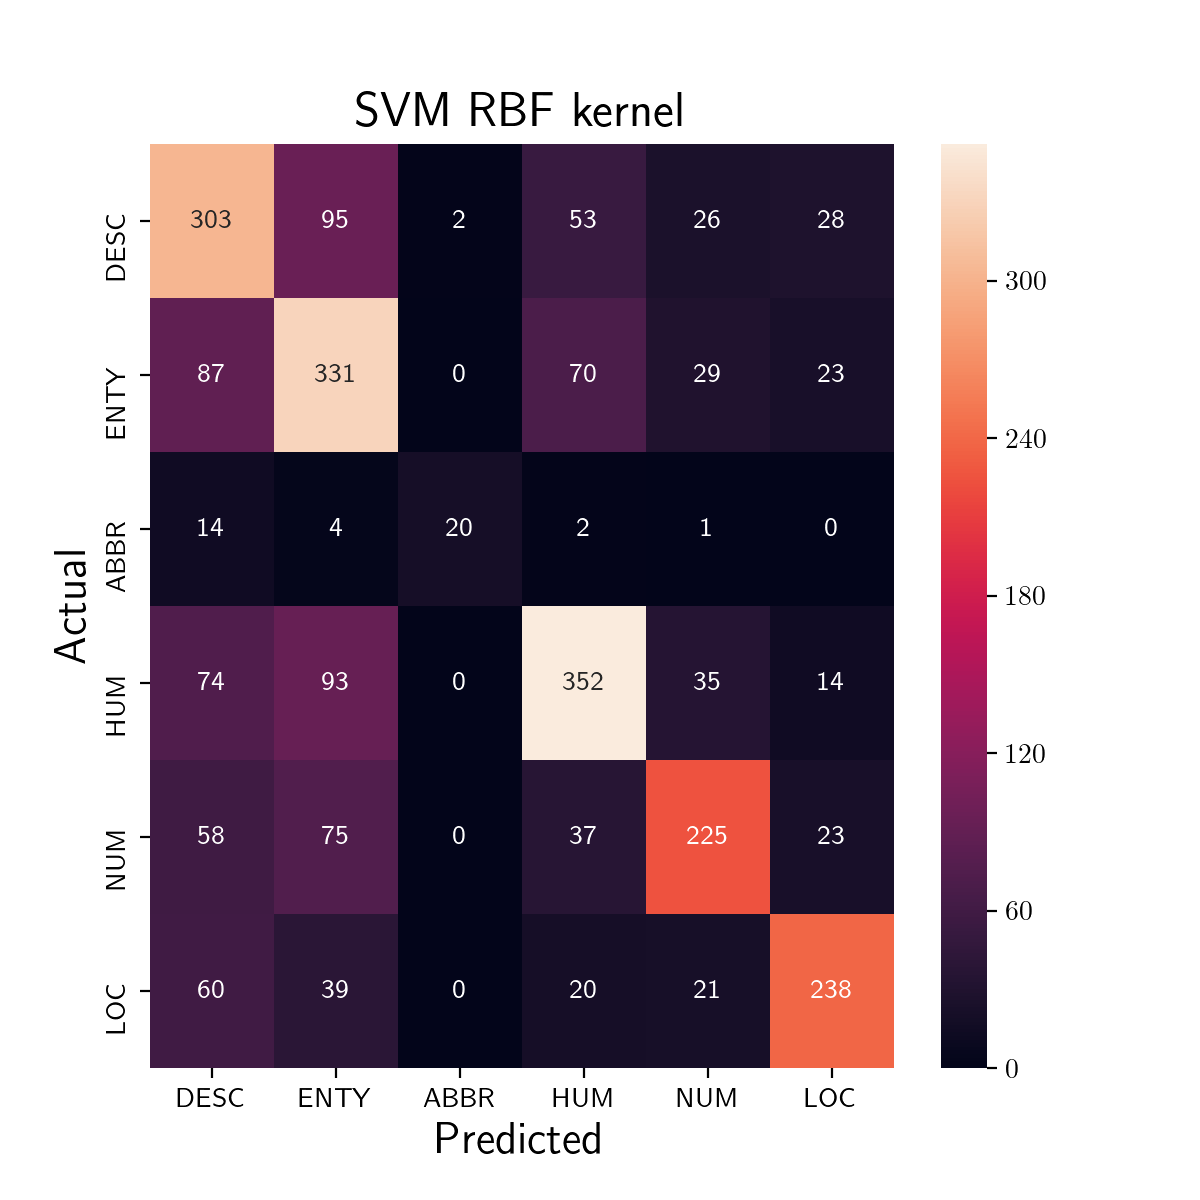

In [73]:
svm_model_rbf = classifier.svm_classifier("rbf", 1e3)
Classifier.test_model(svm_model_rbf, X_test, Y_test, "SVM RBF kernel", category_id_dat.Category1.values, category_id_dat.Category1.values)


### Search optimal parameters for SVM models with grid search

Here we use reduced sample of the dataset `X_train4grid` (only 1000 vectors from 5000) in order to decrease computation time.

In [30]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001,], 
              'kernel': ['rbf']}  

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train4grid, Y_train4grid) 

/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.244, total=   1.6s
[CV] C=0.001, gamma=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.244, total=   1.7s
[CV] C=0.001, gamma=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.244, total=   1.6s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=0.001, gamma=0.1, kernel=rbf, score=0.244, total=   1.6s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=0.001, gamma=0.1, kernel=rbf, score=0.244, total=   1.6s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=0.001, gamma=0.1, kernel=rbf, score=0.244, total=   1.6s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.244, total=   1.6s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.244, total=   1.6s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.244, total=   1.6s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] .

[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.244, total=   1.8s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.244, total=   1.8s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.244, total=   1.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.244, total=   1.7s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.244, total=   1.7s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.244, total=   1.7s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.244, total=   1.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  3.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

<IPython.core.display.Javascript object>


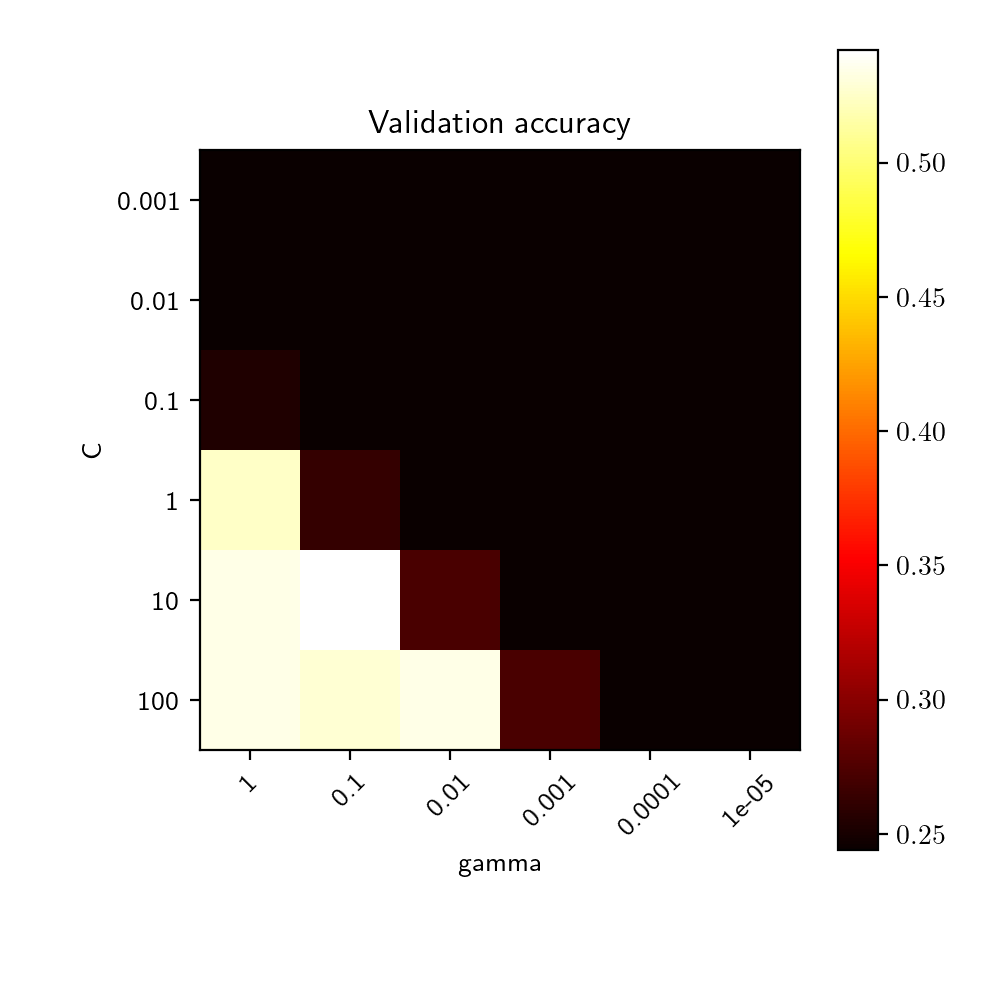

Best model parameters for SVM: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'} with score 0.542


In [74]:
scores = grid.cv_results_['mean_test_score'].reshape(len(param_grid["C"]), len(param_grid["gamma"]))

best_param = grid.best_params_

plt.figure(figsize=(5, 5))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid["gamma"])), param_grid["gamma"], rotation=45)
plt.yticks(np.arange(len(param_grid["C"])), param_grid["C"])
plt.title('Validation accuracy')
plt.savefig(os.getcwd() + "/doc/imgs/grid_param_svm.png", dpi=300)
plt.show()

print("Best model parameters for SVM: {} with score {}".format(grid.best_params_, grid.best_score_))


#### Test model with optimal parameters 

<IPython.core.display.Javascript object>


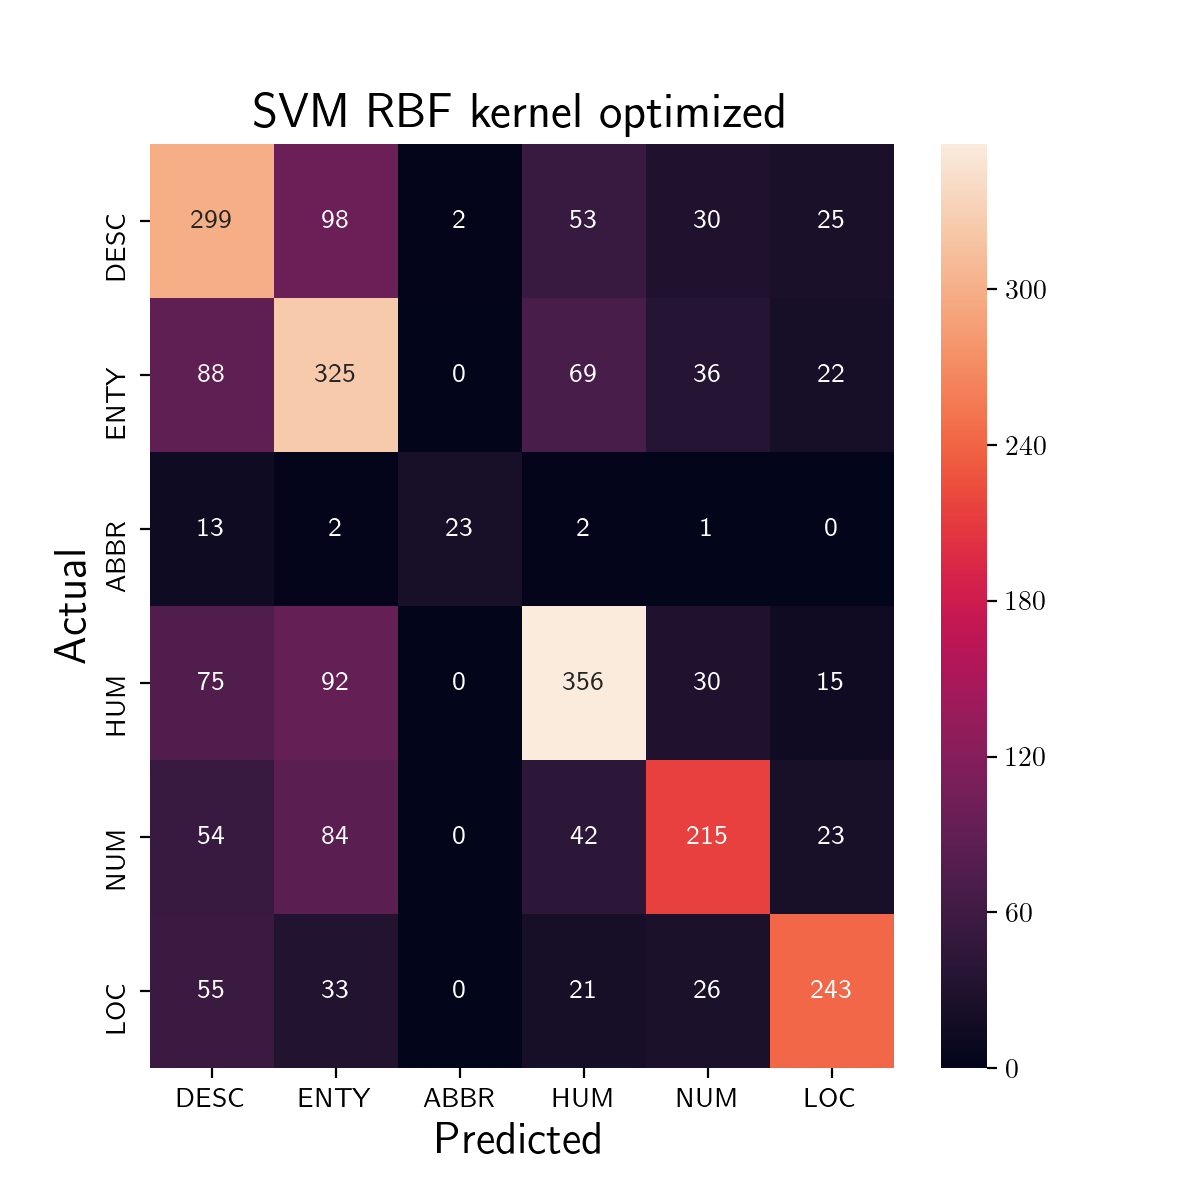

In [75]:
svm_model_rbf_opt = classifier.svm_classifier("rbf", grid.best_params_["C"], grid.best_params_["gamma"])
Classifier.test_model(svm_model_rbf_opt, X_test, Y_test, "SVM RBF kernel optimized", category_id_dat.Category1.values, category_id_dat.Category1.values)


### Random forest classifier

In [41]:
forest_model = classifier.random_forest_classifier()

<IPython.core.display.Javascript object>


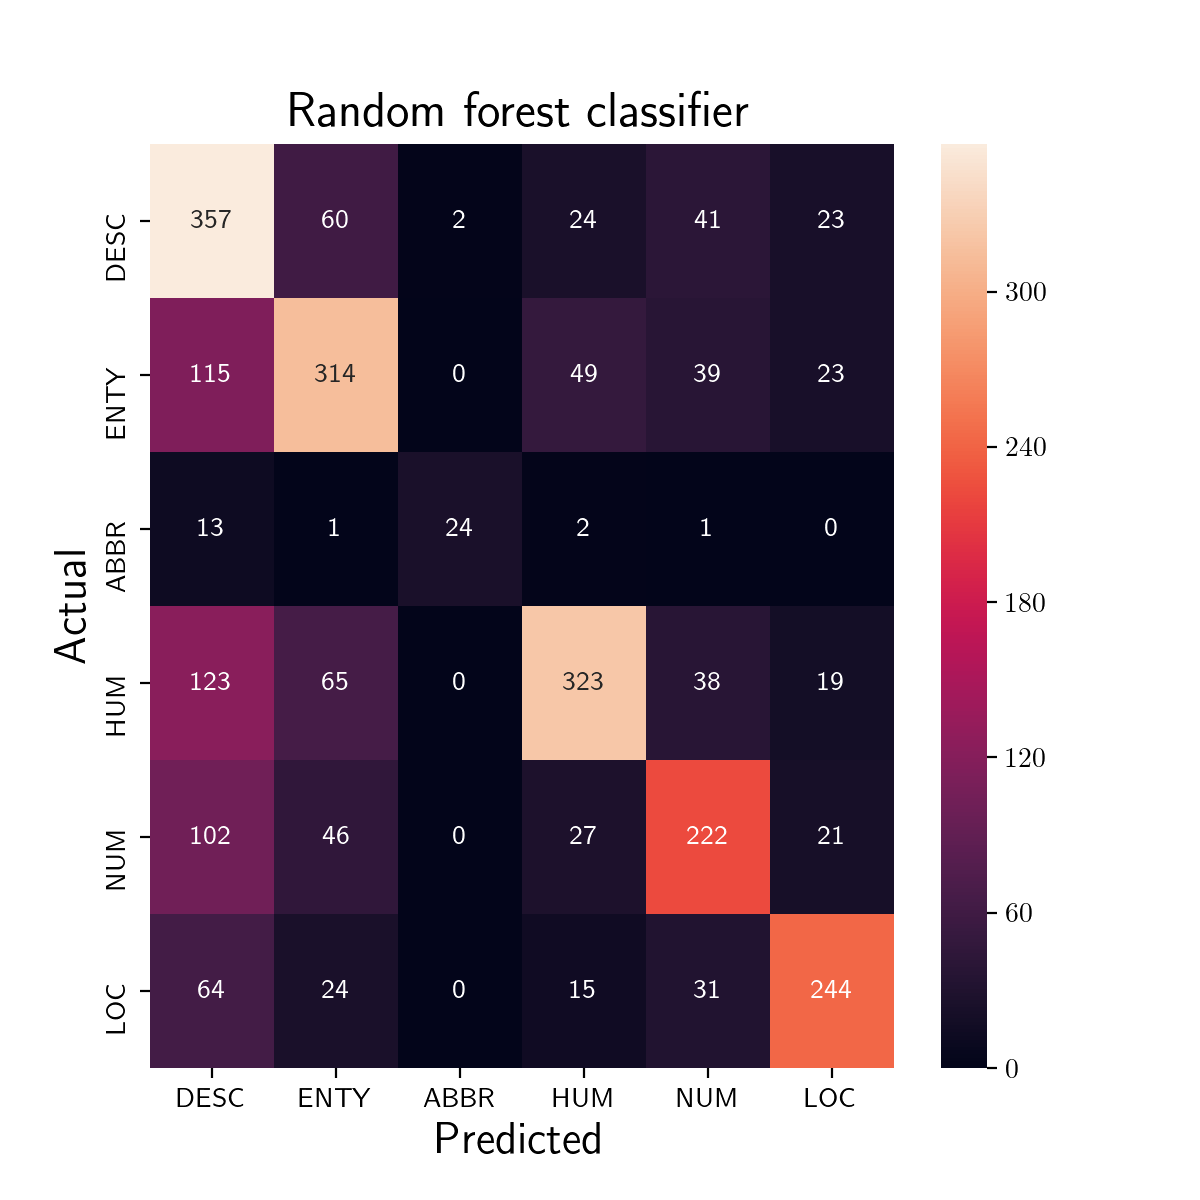

In [76]:
Classifier.test_model(forest_model, X_test, Y_test, "Random forest classifier", category_id_dat.Category1.values, category_id_dat.Category1.values)


### Logistic regression

In [49]:
logist_model = classifier.logistic_regression_classifier()

<IPython.core.display.Javascript object>


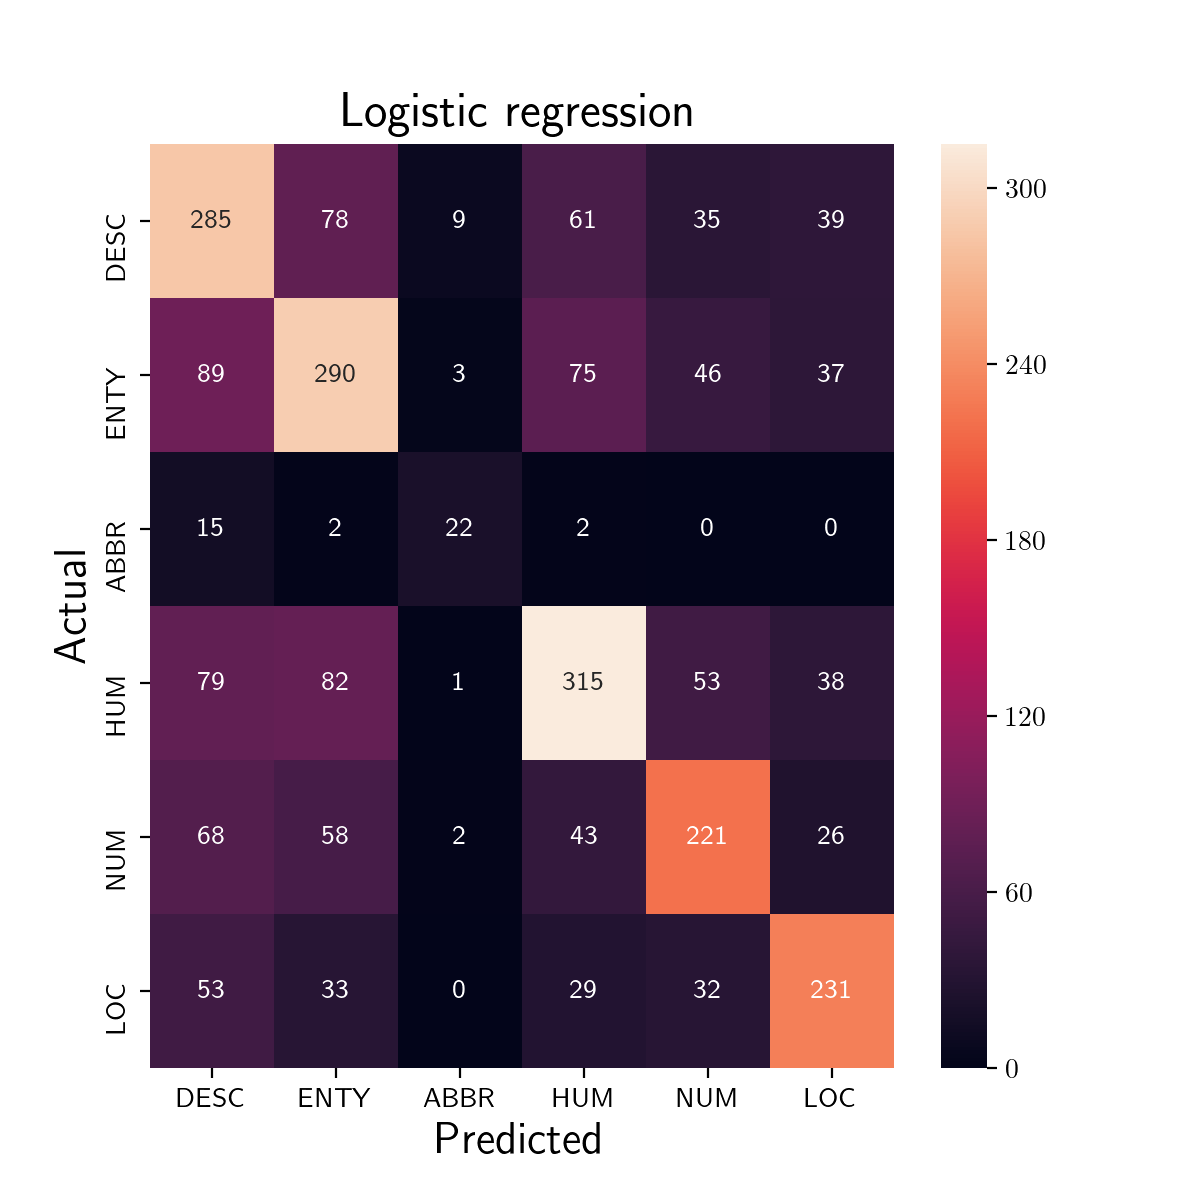

In [77]:
Classifier.test_model(logist_model, X_test, Y_test, "Logistic regression", category_id_dat.Category1.values, category_id_dat.Category1.values)


The vast majority of the predictions end up on the diagonal for all methods (predicted label = actual label), where we want them to be. Note, for `ABBR` also majority of the cases is classified properly but relative smallnes of this class leads to the characteristic "cross" on the confusion matrix.

### Algorithm comparison

In [51]:
models = [
    ["RFC", RandomForestClassifier(n_jobs=2, n_estimators=100)],
    ["SVM:lin", SVC(kernel="linear", gamma="auto")],
    ["SVM:rbf", SVC(kernel="rbf", C=10, gamma=0.1)],
    ["Logist", LogisticRegression(random_state=0, solver='liblinear', multi_class='auto')],
]

results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_test, Y_test, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



RFC: 0.580758 (0.023882)
SVM:lin: 0.593005 (0.034062)
SVM:rbf: 0.589336 (0.024574)
Logist: 0.601960 (0.019014)


<IPython.core.display.Javascript object>


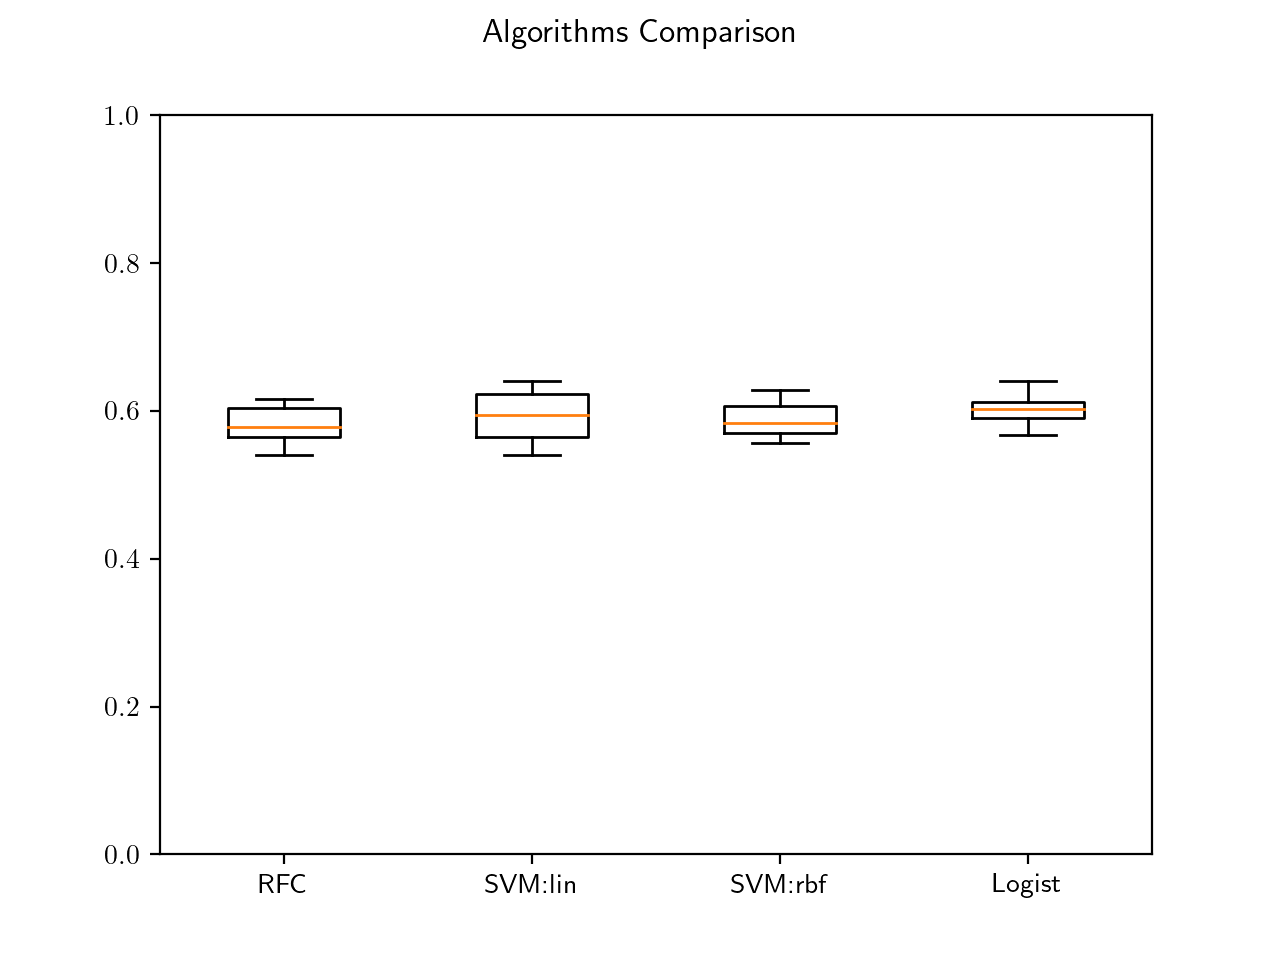

In [54]:
fig = plt.figure()
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylim(0, 1)
plt.savefig(os.getcwd() + "/doc/imgs/alg_compt.png", dpi=300)
plt.show()